**Load Libraries**

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import brier_score_loss, auc

from keras.models import Sequential
from keras.layers import Dense, LSTM


**Load Dataset**

In [91]:
data = pd.read_csv('estonia_passenger_list.csv')
data.describe()

,PassengerId,Age,Survived
count,989.000000,989.000000,989.000000
mean,494.992922,44.575329,0.138524
std,285.643660,17.235146,0.345624
min,1.000000,0.000000,0.000000
25%,248.000000,30.000000,0.000000
50%,495.000000,44.000000,0.000000
75%,742.000000,59.000000,0.000000
max,989.000000,87.000000,1.000000


**Dataset Overview**

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  989 non-null    int64 
 1   Country      989 non-null    object
 2   Firstname    989 non-null    object
 3   Lastname     989 non-null    object
 4   Sex          989 non-null    object
 5   Age          989 non-null    int64 
 6   Category     989 non-null    object
 7   Survived     989 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 61.9+ KB


**Missing Value Imputation**

In [43]:
def impute_missing_values(df):
    for col in df.columns:

        if df[col].dtype != 'object':

            df[col].fillna(df[col].median(), inplace=True)

        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df

data = impute_missing_values(data)

In [44]:
data.head()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category,Survived
0,1,Sweden,ARVID KALLE,AADLI,M,62,P,0
1,2,Estonia,LEA,AALISTE,F,22,C,0
2,3,Estonia,AIRI,AAVASTE,F,21,C,0
3,4,Sweden,JURI,AAVIK,M,53,C,0
4,5,Sweden,BRITTA ELISABET,AHLSTROM,F,55,P,0


**Feature and label separation for your dataset**

In [45]:
features = data.iloc[:, :-1]
labels = data.iloc[:, -1]

In [46]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data.copy()
categorical_cols = data_encoded.select_dtypes(include=['object']).columns

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))
    label_encoders[col] = le

features = data_encoded.drop('Survived', axis=1)
labels = data_encoded['Survived']


**Target Distribution Check**

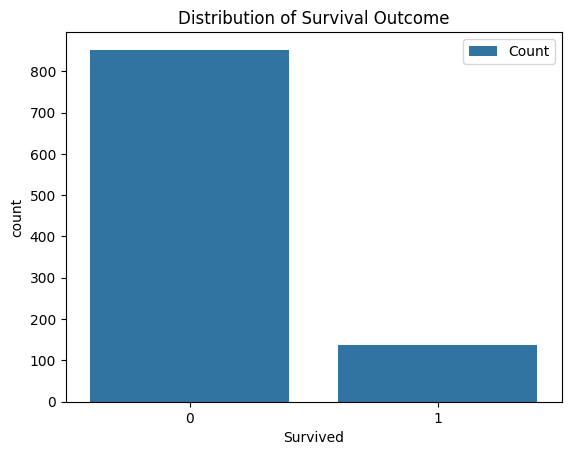

=== Survival Outcome Distribution ===
Total Samples           : 989
Survived (1) Count      : 852
Survived (1) Percentage : 86.15%
Not Survived (0) Count  : 137
Not Survived (0) %      : 13.85%



In [47]:
sns.countplot(x=labels, label="Count")
plt.title("Distribution of Survival Outcome")
plt.show()

positive_outcomes, negative_outcomes = labels.value_counts()
total_samples = labels.count()

print("=== Survival Outcome Distribution ===")
print(f"Total Samples           : {total_samples}")
print(f"Survived (1) Count      : {positive_outcomes}")
print(f"Survived (1) Percentage : {round((positive_outcomes / total_samples) * 100, 2)}%")
print(f"Not Survived (0) Count  : {negative_outcomes}")
print(f"Not Survived (0) %      : {round((negative_outcomes / total_samples) * 100, 2)}%")
print("=====================================\n")


**Correlation Matrix Heatmap**

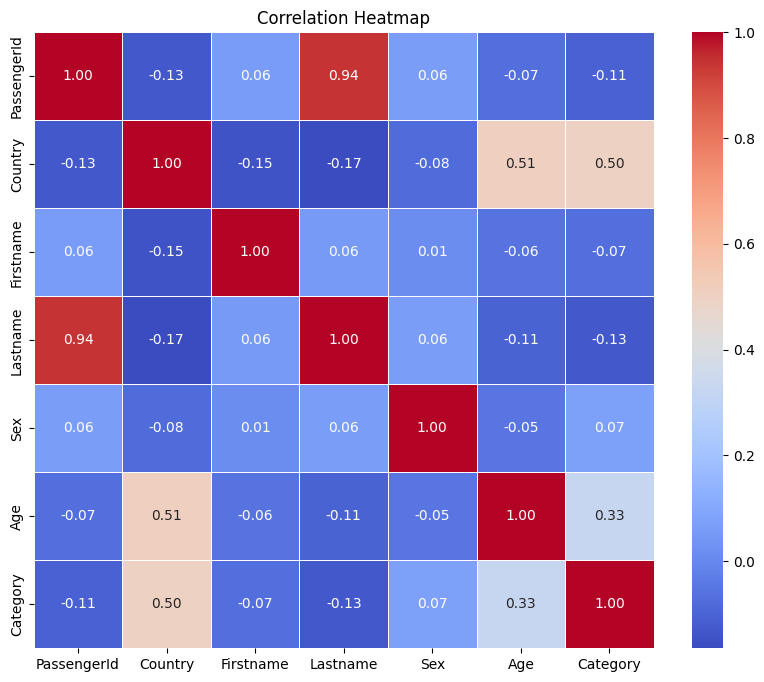

In [74]:
numeric_features = features.select_dtypes(include=['int64', 'float64'])

fig, axis = plt.subplots(figsize=(10, 8))
correlation_matrix = numeric_features.corr()

sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt='.2f', cmap='coolwarm', ax=axis)
plt.title("Correlation Heatmap")
plt.show()


**Histograms**

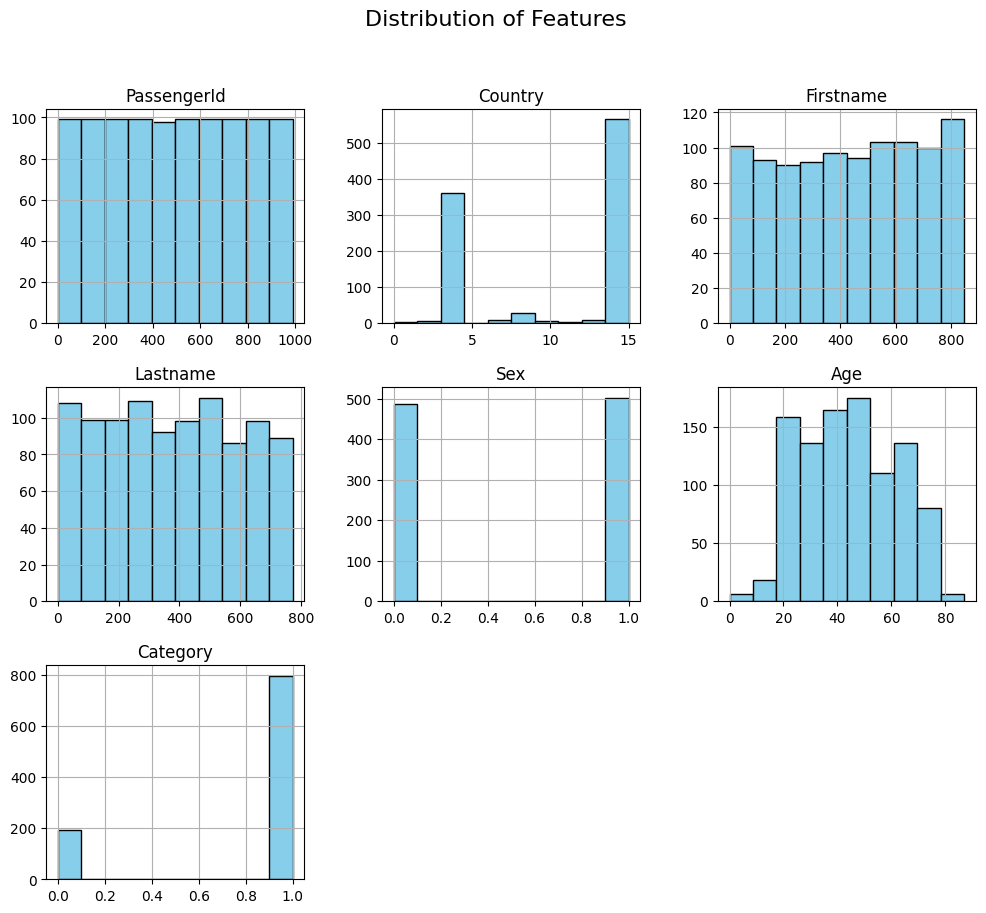

In [72]:
numeric_features = features.select_dtypes(include=['int64', 'float64'])

numeric_features.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Features", fontsize=16)
plt.show()


**Pair Plot**

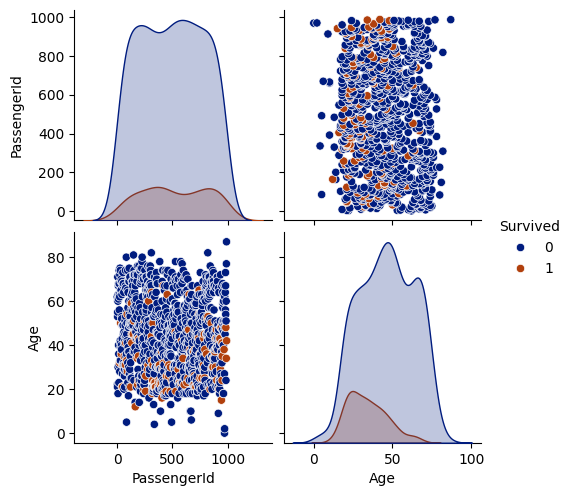

In [71]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Survived' in numeric_cols:
    numeric_cols.remove('Survived')

pairplot_cols = numeric_cols[:4]

sns.pairplot(data[pairplot_cols + ['Survived']], hue='Survived', palette='dark')
plt.show()


**Train–Test Split**

In [52]:
features_train_all, features_test_all, labels_train_all, labels_test_all = \
train_test_split(
    features,
    labels,
    test_size=0.1,
    random_state=21,
    stratify=labels
)

for dataset in [features_train_all, features_test_all, labels_train_all, labels_test_all]:
    dataset.reset_index(drop=True, inplace=True)

numeric_cols = features_train_all.select_dtypes(include=['int64', 'float64']).columns

features_train_all_std = features_train_all.copy()
features_train_all_std[numeric_cols] = (
    features_train_all[numeric_cols] - features_train_all[numeric_cols].mean()
) / features_train_all[numeric_cols].std()

features_test_all_std = features_test_all.copy()
features_test_all_std[numeric_cols] = (
    features_test_all[numeric_cols] - features_test_all[numeric_cols].mean()
) / features_test_all[numeric_cols].std()

features_train_all_std.describe()

,PassengerId,Country,Firstname,Lastname,Sex,Age,Category
count,8.900000e+02,8.900000e+02,8.900000e+02,8.900000e+02,8.900000e+02,8.900000e+02,8.900000e+02
mean,3.193450e-17,-1.596725e-17,-3.991813e-17,4.390994e-17,1.457012e-16,-7.185264e-17,4.390994e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.727689e+00,-1.787188e+00,-1.742721e+00,-1.672755e+00,-1.029074e+00,-2.592964e+00,-2.034663e+00
25%,-8.702026e-01,-1.262469e+00,-8.660373e-01,-8.657970e-01,-1.029074e+00,-8.489936e-01,4.909298e-01
50%,4.765284e-03,8.364054e-01,2.866056e-02,7.943895e-03,9.706553e-01,-3.514068e-02,4.909298e-01
75%,8.692441e-01,8.364054e-01,8.783233e-01,8.471804e-01,9.706553e-01,7.787122e-01,4.909298e-01
max,1.726730e+00,8.364054e-01,1.651927e+00,1.768782e+00,9.706553e-01,2.173889e+00,4.909298e-01


**Calculate Classification Metrics**

In [53]:
def calc_metrics(conf_matrix):

    TP = conf_matrix[0][0]
    FN = conf_matrix[0][1]
    FP = conf_matrix[1][0]
    TN = conf_matrix[1][1]

    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0
    FPR = FP / (TN + FP) if (TN + FP) != 0 else 0
    FNR = FN / (TP + FN) if (TP + FN) != 0 else 0
    Precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    F1_measure = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = (
        2 * (TP * TN - FP * FN) /
        ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
        if ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)) != 0 else 0
    )

    return [
        TP, TN, FP, FN,
        TPR, TNR, FPR, FNR,
        Precision, F1_measure, Accuracy, Error_rate,
        BACC, TSS, HSS
    ]



def get_metrics(model, X_train, X_test, y_train, y_test, LSTM_flag):

    def calc_metrics(conf_matrix):
        TP, FN = conf_matrix[0][0], conf_matrix[0][1]
        FP, TN = conf_matrix[1][0], conf_matrix[1][1]

        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        FPR = FP / (TN + FP)
        FNR = FN / (TP + FN)
        Precision = TP / (TP + FP)
        F1_measure = 2 * TP / (2 * TP + FP + FN)
        Accuracy = (TP + TN) / (TP + FP + FN + TN)
        Error_rate = (FP + FN) / (TP + FP + FN + TN)
        BACC = (TPR + TNR) / 2
        TSS = TPR - FPR
        HSS = 2 * (TP * TN - FP * FN) / (
            (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
        )

        return [
            TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure,
            Accuracy, Error_rate, BACC, TSS, HSS
        ]

    metrics = []

    if LSTM_flag == 1:

        model.fit(X_train, y_train, epochs=10, verbose=0)

        y_pred_prob = model.predict(X_test).ravel()

        y_pred = (y_pred_prob > 0.5).astype(int)

        matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])

        brier = brier_score_loss(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)

        metrics.extend(calc_metrics(matrix))
        metrics.extend([brier, auc, 0])

        return metrics
    else:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        matrix = confusion_matrix(y_test, y_pred, labels=[1, 0])

        y_pred_prob = model.predict_proba(X_test)[:, 1]

        brier = brier_score_loss(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        acc = model.score(X_test, y_test)

        metrics.extend(calc_metrics(matrix))
        metrics.extend([brier, auc, acc])

        return metrics


**KNN**

In [54]:
knn_parameters = {
    "n_neighbors": list(range(1, 16))
}

knn_model = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_parameters,
    cv=10,
    n_jobs=-1
)

knn_cv.fit(features_train_all_std, labels_train_all)
print("===== KNN GridSearchCV Results =====")
print(f"Best Number of Neighbors (n_neighbors): {knn_cv.best_params_['n_neighbors']}")
print("\n")

===== KNN GridSearchCV Results =====
Best Number of Neighbors (n_neighbors): 10




In [55]:
best_n_neighbors = knn_cv.best_params_['n_neighbors']
best_n_neighbors

10

**Random Forest**

In [56]:
param_grid_rf = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_samples_split": [2, 4, 6, 8, 10]
}

rf_classifier = RandomForestClassifier()

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=10,
    n_jobs=-1
)

grid_search_rf.fit(features_train_all_std, labels_train_all)

best_rf_params = grid_search_rf.best_params_
print("===== Random Forest GridSearchCV Results =====")
print(f"Best n_estimators       : {best_rf_params['n_estimators']}")
print(f"Best min_samples_split  : {best_rf_params['min_samples_split']}")
print("\n")


min_samples_split = best_rf_params['min_samples_split']
n_estimators = best_rf_params['n_estimators']


===== Random Forest GridSearchCV Results =====
Best n_estimators       : 70
Best min_samples_split  : 4




**SVM**

In [57]:
param_grid_svc = {
    "kernel": ["linear"],
    "C": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

svc_classifier = SVC(probability=True)

grid_search_svc = GridSearchCV(
    estimator=svc_classifier,
    param_grid=param_grid_svc,
    cv=10,
    n_jobs=-1
)

grid_search_svc.fit(features_train_all_std, labels_train_all)

best_svc_params = grid_search_svc.best_params_
print("===== Support Vector Machine GridSearchCV Results =====")
print(f"Best Kernel : {best_svc_params['kernel']}")
print(f"Best C Value: {best_svc_params['C']}")
print("\n")


C_value = best_svc_params['C']

===== Support Vector Machine GridSearchCV Results =====
Best Kernel : linear
Best C Value: 1




**Stratified K-Fold Cross Validator**

In [58]:
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

In [59]:
metric_columns = [
    'TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR',
    'Precision', 'F1_measure', 'Accuracy', 'Error_rate',
    'BACC', 'TSS', 'HSS', 'Brier_score', 'AUC', 'Acc_by_package_fn'
]

knn_metrics_list = []
rf_metrics_list = []
svm_metrics_list = []
lstm_metrics_list = []

print("Starting 10-fold cross-validation...\n")

for iter_num, (train_index, test_index) in enumerate(
    cv_stratified.split(features_train_all_std, labels_train_all), start=1):

    features_train = features_train_all_std.iloc[train_index, :]
    features_test = features_train_all_std.iloc[test_index, :]

    labels_train = labels_train_all[train_index]
    labels_test = labels_train_all[test_index]

    # KNN
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

    # Random Forest
    rf_model = RandomForestClassifier(
        min_samples_split=min_samples_split,
        n_estimators=n_estimators
    )

    # SVM
    svm_model = SVC(C=C_value, kernel='linear', probability=True)

    X_train_lstm = np.array(features_train).reshape(-1, 1, features_train.shape[1])
    X_test_lstm = np.array(features_test).reshape(-1, 1, features_test.shape[1])

    # LSTM
    lstm_model = Sequential()
    lstm_model.add(LSTM(
        64,
        activation='relu',
        input_shape=(1, features_train.shape[1])
    ))
    lstm_model.add(Dense(1, activation='sigmoid'))

    lstm_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    knn_metrics = get_metrics(knn_model, features_train, features_test, labels_train, labels_test, 0)
    rf_metrics = get_metrics(rf_model, features_train, features_test, labels_train, labels_test, 0)
    svm_metrics = get_metrics(svm_model, features_train, features_test, labels_train, labels_test, 0)
    lstm_metrics = get_metrics(lstm_model, X_train_lstm, X_test_lstm, labels_train, labels_test, 1)

    knn_metrics_list.append(knn_metrics)
    rf_metrics_list.append(rf_metrics)
    svm_metrics_list.append(svm_metrics)
    lstm_metrics_list.append(lstm_metrics)

    metrics_all_df = pd.DataFrame(
        [knn_metrics, rf_metrics, svm_metrics, lstm_metrics],
        columns=metric_columns,
        index=['KNN', 'RF', 'SVM', 'LSTM']
    )

    print(f"\nMetrics in Iteration {iter_num}:-\n")
    print(metrics_all_df.round(decimals=2).T)
    print("\n")

Starting 10-fold cross-validation...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Metrics in Iteration 1:-

                     KNN     RF    SVM   LSTM
TP                  0.00   3.00   0.00   0.00
TN                 77.00  77.00  77.00  77.00
FP                  0.00   0.00   0.00   0.00
FN                 12.00   9.00  12.00  12.00
TPR                 0.00   0.25   0.00   0.00
TNR                 1.00   1.00   1.00   1.00
FPR                 0.00   0.00   0.00   0.00
FNR                 1.00   0.75   1.00   1.00
Precision            NaN   1.00    NaN    NaN
F1_measure          0.00   0.40   0.00   0.00
Accuracy            0.87   0.90   0.87   0.87
Error_rate          0.13   0.10   0.13   0.13
BACC                0.50   0.62   0.50   0.50
TSS                 0.00   0.25   0.00   0.00
HSS                 0.00   0.37   0.00   0.00
Brier_score         0.12   0.09   0.12   0.11
AUC                 0.71   0.87   0.35   0.72
Acc_by_package_fn   0.87   0.90   0.87   0.00


3/3 ━━━━━━━━━━━━━━━━

**Metrics for Each Algorithm**

In [79]:
metric_index_df = [
    'iter1', 'iter2', 'iter3', 'iter4', 'iter5',
    'iter6', 'iter7', 'iter8', 'iter9', 'iter10'
]

knn_metrics_df = pd.DataFrame(knn_metrics_list, columns=metric_columns, index=metric_index_df)
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns, index=metric_index_df)
svm_metrics_df = pd.DataFrame(svm_metrics_list, columns=metric_columns, index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns, index=metric_index_df)

algorithm_names = ["KNN", "Random Forest", "SVM", "LSTM"]
metrics_dfs = [knn_metrics_df, rf_metrics_df, svm_metrics_df, lstm_metrics_df]

for name, df in zip(algorithm_names, metrics_dfs):
    print(f"\n===== Metrics for {name} =====\n")
    print(df.round(3).T.to_string())





===== Metrics for KNN =====

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7   iter8   iter9  iter10
TP                  0.000   0.000   0.000   0.000   1.000   0.000   0.000   0.000   0.000   0.000
TN                 77.000  77.000  77.000  75.000  76.000  77.000  76.000  76.000  75.000  76.000
FP                  0.000   0.000   0.000   2.000   1.000   0.000   1.000   0.000   1.000   0.000
FN                 12.000  12.000  12.000  12.000  11.000  12.000  12.000  13.000  13.000  13.000
TPR                 0.000   0.000   0.000   0.000   0.083   0.000   0.000   0.000   0.000   0.000
TNR                 1.000   1.000   1.000   0.974   0.987   1.000   0.987   1.000   0.987   1.000
FPR                 0.000   0.000   0.000   0.026   0.013   0.000   0.013   0.000   0.013   0.000
FNR                 1.000   1.000   1.000   1.000   0.917   1.000   1.000   1.000   1.000   1.000
Precision             NaN     NaN     NaN   0.000   0.500     NaN   0.000     NaN   0.00

**Average metrics for each algorithm**

In [61]:
knn_avg_df = knn_metrics_df.mean()
rf_avg_df = rf_metrics_df.mean()
svm_avg_df = svm_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()

avg_performance_df = pd.DataFrame(
    {
        'KNN': knn_avg_df,
        'RF': rf_avg_df,
        'SVM': svm_avg_df,
        'LSTM': lstm_avg_df
    },
    index=metric_columns
)

print("\n===== Average Performance of All Algorithms (10-Fold CV) =====\n")
print(avg_performance_df.round(2))
print("\n")



===== Average Performance of All Algorithms (10-Fold CV) =====

                     KNN     RF    SVM   LSTM
TP                  0.10   0.80   0.00   0.00
TN                 76.20  74.40  76.70  76.70
FP                  0.50   2.30   0.00   0.00
FN                 12.20  11.50  12.30  12.30
TPR                 0.01   0.06   0.00   0.00
TNR                 0.99   0.97   1.00   1.00
FPR                 0.01   0.03   0.00   0.00
FNR                 0.99   0.94   1.00   1.00
Precision           0.12   0.21    NaN    NaN
F1_measure          0.01   0.10   0.00   0.00
Accuracy            0.86   0.84   0.86   0.86
Error_rate          0.14   0.16   0.14   0.14
BACC                0.50   0.52   0.50   0.50
TSS                 0.00   0.03   0.00   0.00
HSS                 0.00   0.05   0.00   0.00
Brier_score         0.12   0.11   0.12   0.11
AUC                 0.70   0.75   0.53   0.74
Acc_by_package_fn   0.86   0.84   0.86   0.00




**KNN ROC Curve and AUC Scores**

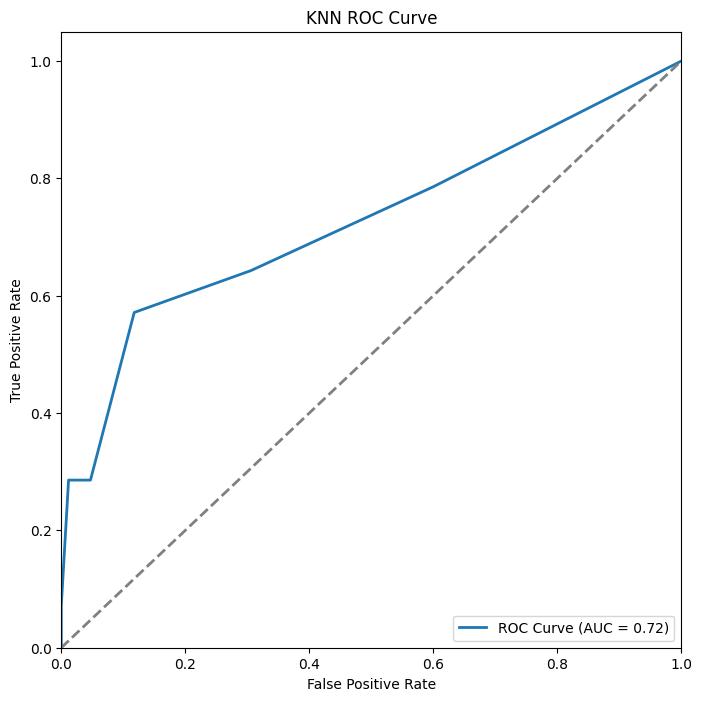

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_model.fit(features_train_all_std, labels_train_all)

y_score = knn_model.predict_proba(features_test_all_std)[:, 1]

fpr, tpr, _ = roc_curve(labels_test_all, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.show()


**Random Forest ROC Curve and AUC Scores**

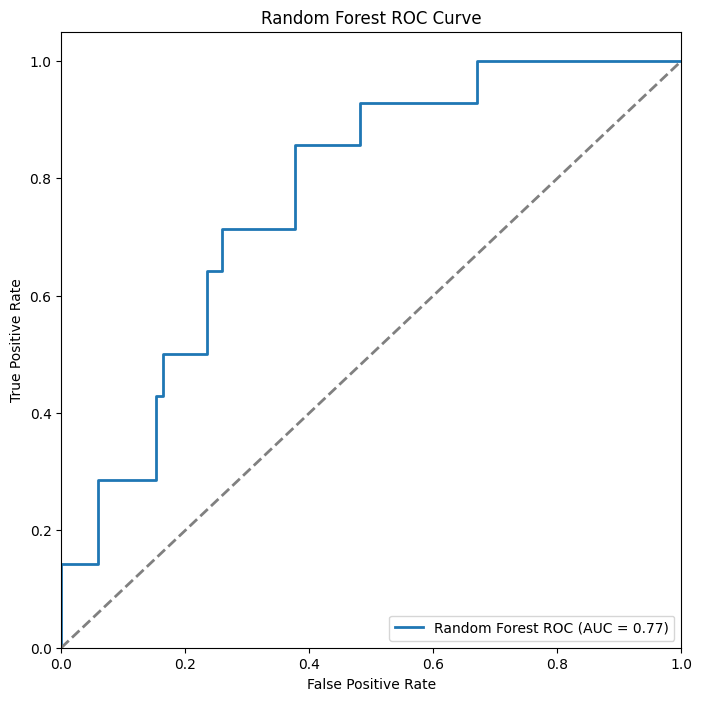

In [63]:
rf_model = RandomForestClassifier(
    min_samples_split=min_samples_split,
    n_estimators=n_estimators
)
rf_model.fit(features_train_all_std, labels_train_all)

y_score_rf = rf_model.predict_proba(features_test_all_std)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(labels_test_all, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, lw=2, label="Random Forest ROC (AUC = {:.2f})".format(roc_auc_rf))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()


**SVM ROC Curve and AUC Scores**

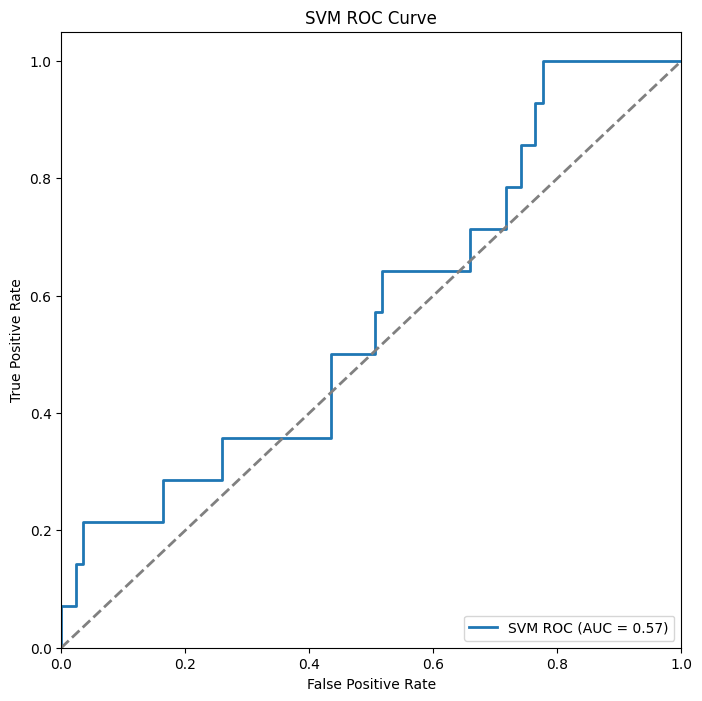

In [68]:
svm_model = SVC(C=C_value, kernel='linear', probability=True)
svm_model.fit(features_train_all_std, labels_train_all)

y_score_svm = svm_model.predict_proba(features_test_all_std)[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(labels_test_all, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, lw=2, label="SVM ROC (AUC = {:.2f})".format(roc_auc_svm))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()


**LSTM ROC Curve and AUC Scores**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


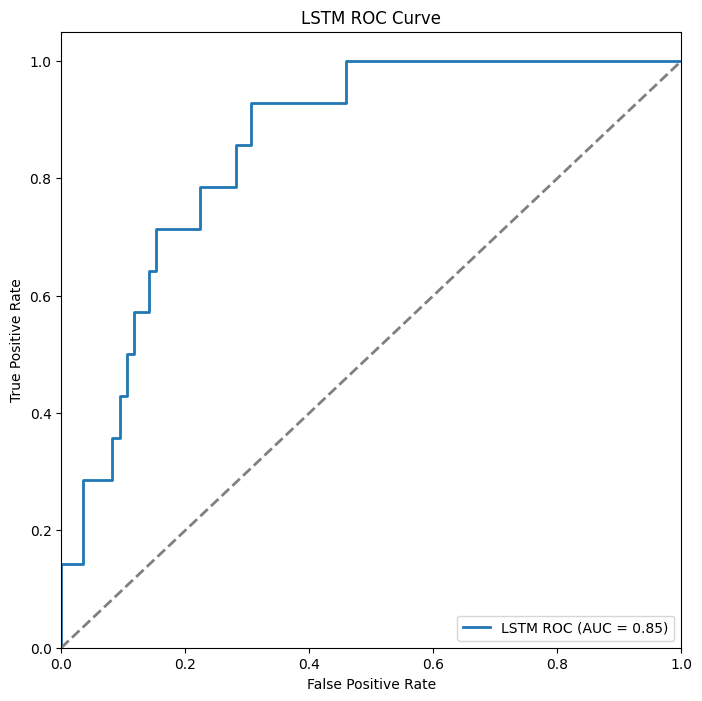

In [66]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(features_train_all_std.shape[1], 1)))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train_array = features_train_all_std.to_numpy()
X_test_array = features_test_all_std.to_numpy()
y_train_array = labels_train_all.to_numpy()
y_test_array = labels_test_all.to_numpy()

X_train_lstm = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_test_lstm = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)

lstm_model.fit(X_train_lstm, y_train_array, epochs=50,
               validation_data=(X_test_lstm, y_test_array), verbose=0)

y_score_lstm = lstm_model.predict(X_test_lstm).ravel()

fpr_lstm, tpr_lstm, _ = roc_curve(y_test_array, y_score_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(8, 8))
plt.plot(fpr_lstm, tpr_lstm, lw=2, label="LSTM ROC (AUC = {:.2f})".format(roc_auc_lstm))
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.show()


**Average Performance**